This notebook contains the Twitter data experiment results where we applied HNTF (Cichocki et al.) to the video tensor. Due to the non-convexity of the NCPD task, results will vary run to run, so the results from this notebook will not exactly match those in the paper.

In [1]:
# loading packages and functions
import torch
import numpy as np
from matplotlib import pyplot as plt

import sys
sys.path.append("./src")

from NNCPD import outer_product, outer_product_np

import torch.nn as nn
from torch.autograd import Variable

import tensorly as tl
from tensorly import unfold as tl_unfold
from tensorly.decomposition import parafac, non_negative_parafac

Using numpy backend.


In [2]:
torch.set_default_tensor_type(torch.DoubleTensor)

words = np.load("./data/words_100.npy", allow_pickle=True)
X = np.load("./data/tweets_bag_100.npy", allow_pickle=True)
results = np.load("./data/results_twitter_ncpd.npy", allow_pickle=True).item()

# Here we load in the initial factor matrices to make sure they are the same accross comparisons
X_1 = results['X_1']
X_2 = results['X_2']
X_3 = results['X_3']

X = X.reshape((8, 10, -1))

# Candidates at Mode 1

In [3]:
def cichocki(X, r, initial_factors = None):
    """
    Given a 3-mode tensor X and a list of rank r, computes the Chichocki HCNPD factorization.
    """

    if(initial_factors == None):
        factors = non_negative_parafac(X, r[0])
    else:  
        factors = initial_factors # This is to make sure all methods have the same initial factorization
    
    A, D, S = factors[0], factors[1], factors[2]
    factorizations = [[A, D, S]]

    for i in range(1, len(r)):

        factors = non_negative_parafac(outer_product_np(np.identity(r[i-1]), D, S), r[i])
        A, D, S = factors[0], factors[1], factors[2]
        factorizations.append([A,D,S])

    return factorizations

In [4]:
#X_tr = np.transpose(X, (2,0,1))
X_tr = X
factorizations = cichocki(X_tr, [8,4,2], initial_factors=[X_1, X_2, X_3])

for i in range(1, len(factorizations)):
    factorizations[i][0] = factorizations[i-1][0] @ factorizations[i][0]
#factorizations = [[x[1], x[2], x[0]] for x in factorizations]

### Topics


RANK 8 KEYWORDS:
------------------
Topic 1          Topic 2     Topic 3     Topic 4  Topic 5     Topic 6        Topic 7        Topic 8    
-------          -------     -------     -------  -------     -------        -------        -------    
martinomalley    marcorubio  johnkasich  crooked  tedcruz     senate         berniesanders  trump      
hillaryclinton   teammarco   kasich      hillary  cruz        florida        people         hillary    
realdonaldtrump  vote        ohio        thank    ted         zika           bernie         donald     
campaigning      flsen       john        great    internet    venezuela      must           president  
maryland         click       gov         clinton  choosecruz  nicolasmaduro  change         timkaine   

For LaTeX table...
------------------
martinomalley & marcorubio & johnkasich & crooked \\
hillaryclinton & teammarco & kasich & hillary \\
realdonaldtrump & vote & ohio & thank \\
campaigning & flsen & john & great \\
maryland & clic

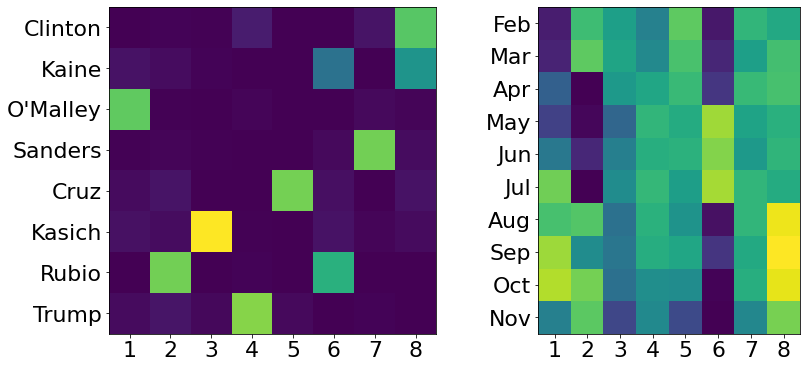


RANK 4 KEYWORDS:
------------------
Topic 1          Topic 2     Topic 3     Topic 4        
-------          -------     -------     -------        
hillary          tedcruz     marcorubio  berniesanders  
trump            cruz        teammarco   people         
realdonaldtrump  ted         vote        bernie         
crooked          internet    flsen       must           
hillaryclinton   choosecruz  click       change         

For LaTeX table...
------------------
hillary & tedcruz \\
trump & cruz \\
realdonaldtrump & ted \\
crooked & internet \\
hillaryclinton & choosecruz \\
marcorubio & berniesanders \\
teammarco & people \\
vote & bernie \\
flsen & must \\
click & change \\




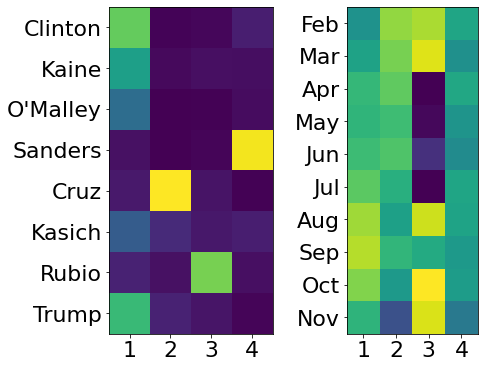


RANK 2 KEYWORDS:
------------------
Topic 1        Topic 2     
-------        -------     
trump          marcorubio  
hillary        teammarco   
tedcruz        vote        
people         flsen       
berniesanders  click       

For LaTeX table...
------------------
trump \\
hillary \\
tedcruz \\
people \\
berniesanders \\
marcorubio \\
teammarco \\
vote \\
flsen \\
click \\




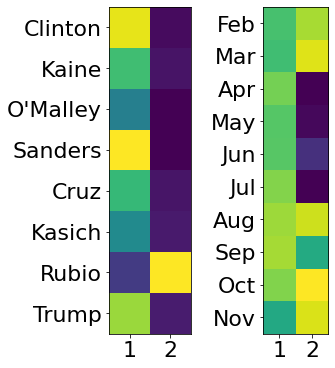

In [5]:
C = factorizations[0][2]

keywords = np.empty((7,8), dtype=object)

for i in range(keywords.shape[1]):
    keywords[0,i] = "Topic " + str(i+1)
    keywords[1,i] = "-------"

for i in range(C.shape[1]):
    col = C[:,i]
    top = col.argsort()
    top = top[-5:][::-1]

    keywords[2:,i] = words[top]

print("")
print("RANK 8 KEYWORDS:")  
print("------------------")
col_widths = [max([len(keywords[i][j]) for i in range(keywords.shape[0])])+2 for j in range(keywords.shape[1])]
for row in keywords:
    print("".join(row[i].ljust(col_widths[i]) for i in range(len(row))))

print("")
print("For LaTeX table...")  
print("------------------")
col_widths = [max([len(keywords[i][j]) for i in range(keywords.shape[0])])+2 for j in range(keywords.shape[1])]
for i, row in enumerate(keywords):
    if(i >= 2):
        print(" & ".join([row[i] for i in range(0,4)]) + " \\\\")
for i, row in enumerate(keywords):
    if(i >= 2):
        print(" & ".join([row[i] for i in range(4,8)]) + " \\\\")
        
print("")
print("")

r = 8
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(12,5))

#color = "binary"
color = "viridis"
plt.sca(axs[0])
plt.yticks(range(8), ['Clinton', 'Kaine', 'O\'Malley', 'Sanders', 'Cruz', 'Kasich', 'Rubio', 'Trump'], fontsize=22)
plt.xticks(range(r), range(1,r+1), fontsize=22)
plt.sca(axs[1])
plt.xticks(range(r), range(1,r+1), fontsize=22)
plt.yticks(range(10), ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'], fontsize=22)

axs[0].imshow(factorizations[0][0], cmap=plt.get_cmap(color))
axs[1].imshow(factorizations[0][1], cmap=plt.get_cmap(color))
plt.show()

C = factorizations[1][2]

keywords = np.empty((7,4), dtype=object)

for i in range(keywords.shape[1]):
    keywords[0,i] = "Topic " + str(i+1)
    keywords[1,i] = "-------"

for i in range(C.shape[1]):
    col = C[:,i]
    top = col.argsort()
    top = top[-5:][::-1]

    keywords[2:,i] = words[top]

print("")
print("RANK 4 KEYWORDS:")  
print("------------------")

col_widths = [max([len(keywords[i][j]) for i in range(keywords.shape[0])])+2 for j in range(keywords.shape[1])]
for row in keywords:
    print("".join(row[i].ljust(col_widths[i]) for i in range(len(row))))

print("")
print("For LaTeX table...")  
print("------------------")
col_widths = [max([len(keywords[i][j]) for i in range(keywords.shape[0])])+2 for j in range(keywords.shape[1])]
for i, row in enumerate(keywords):
    if(i >= 2):
        print(" & ".join([row[i] for i in range(0,2)]) + " \\\\")
for i, row in enumerate(keywords):
    if(i >= 2):
        print(" & ".join([row[i] for i in range(2,4)]) + " \\\\")
        
print("")
print("")

r = 4
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(7,5))

#color = "binary"
color = "viridis"
plt.sca(axs[0])
plt.yticks(range(8), ['Clinton', 'Kaine', 'O\'Malley', 'Sanders', 'Cruz', 'Kasich', 'Rubio', 'Trump'], fontsize=22)
plt.xticks(range(r), range(1,r+1), fontsize=22)
plt.sca(axs[1])
plt.xticks(range(r), range(1,r+1), fontsize=22)
plt.yticks(range(10), ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'], fontsize=22)

axs[0].imshow(factorizations[1][0], cmap=plt.get_cmap(color))
axs[1].imshow(factorizations[1][1], cmap=plt.get_cmap(color))
plt.show()

C = factorizations[2][2]

keywords = np.empty((7,2), dtype=object)

for i in range(keywords.shape[1]):
    keywords[0,i] = "Topic " + str(i+1)
    keywords[1,i] = "-------"

for i in range(C.shape[1]):
    col = C[:,i]
    top = col.argsort()
    top = top[-5:][::-1]

    keywords[2:,i] = words[top]

print("")
print("RANK 2 KEYWORDS:")  
print("------------------")

col_widths = [max([len(keywords[i][j]) for i in range(keywords.shape[0])])+2 for j in range(keywords.shape[1])]
for row in keywords:
    print("".join(row[i].ljust(col_widths[i]) for i in range(len(row))))

print("")
print("For LaTeX table...")  
print("------------------")
col_widths = [max([len(keywords[i][j]) for i in range(keywords.shape[0])])+2 for j in range(keywords.shape[1])]
for i, row in enumerate(keywords):
    if(i >= 2):
        print(" & ".join([row[i] for i in range(0,1)]) + " \\\\")
for i, row in enumerate(keywords):
    if(i >= 2):
        print(" & ".join([row[i] for i in range(1,2)]) + " \\\\")
        
print("")
print("")
r = 2
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(4.8,5))

#color = "binary"
color = "viridis"
plt.sca(axs[0])
plt.yticks(range(8), ['Clinton', 'Kaine', 'O\'Malley', 'Sanders', 'Cruz', 'Kasich', 'Rubio', 'Trump'], fontsize=22)
plt.xticks(range(r), range(1,r+1), fontsize=22)
plt.sca(axs[1])
plt.xticks(range(r), range(1,r+1), fontsize=22)
plt.yticks(range(10), ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'], fontsize=22)

axs[0].imshow(factorizations[2][0], cmap=plt.get_cmap(color))
axs[1].imshow(factorizations[2][1], cmap=plt.get_cmap(color))
plt.show()

In [6]:
for i in range(len(factorizations)):
    
    A, D, S = factorizations[i]

    approx = outer_product_np(A,D,S)
    print("Reconstruction loss:", np.linalg.norm(np.ndarray.flatten(X-approx), 2))
    print("Relative reconstruction loss:", np.linalg.norm(np.ndarray.flatten(X-approx), 2)  / np.linalg.norm(np.ndarray.flatten(X), 2))
    print()

Reconstruction loss: 7.446640570183214
Relative reconstruction loss: 0.8325597259468733

Reconstruction loss: 7.958830875808124
Relative reconstruction loss: 0.8898243429865579

Reconstruction loss: 8.289065368570066
Relative reconstruction loss: 0.9267456817031011



# Time Slices at Mode 1

In [7]:
X_tr = np.transpose(X, (1,0,2))
factorizations = cichocki(X_tr, [8,4,2], initial_factors=[X_2, X_1, X_3])

for i in range(1, len(factorizations)):
    factorizations[i][0] = factorizations[i-1][0] @ factorizations[i][0]
factorizations = [[x[1], x[0], x[2]] for x in factorizations]

### Topics


RANK 8 KEYWORDS:
------------------
Topic 1          Topic 2     Topic 3     Topic 4  Topic 5     Topic 6        Topic 7        Topic 8    
-------          -------     -------     -------  -------     -------        -------        -------    
martinomalley    marcorubio  johnkasich  crooked  tedcruz     senate         berniesanders  trump      
hillaryclinton   teammarco   kasich      hillary  cruz        florida        people         hillary    
realdonaldtrump  vote        ohio        thank    ted         zika           bernie         donald     
campaigning      flsen       john        great    internet    venezuela      must           president  
maryland         click       gov         clinton  choosecruz  nicolasmaduro  change         timkaine   

For LaTeX table...
------------------
martinomalley & marcorubio & johnkasich & crooked \\
hillaryclinton & teammarco & kasich & hillary \\
realdonaldtrump & vote & ohio & thank \\
campaigning & flsen & john & great \\
maryland & clic

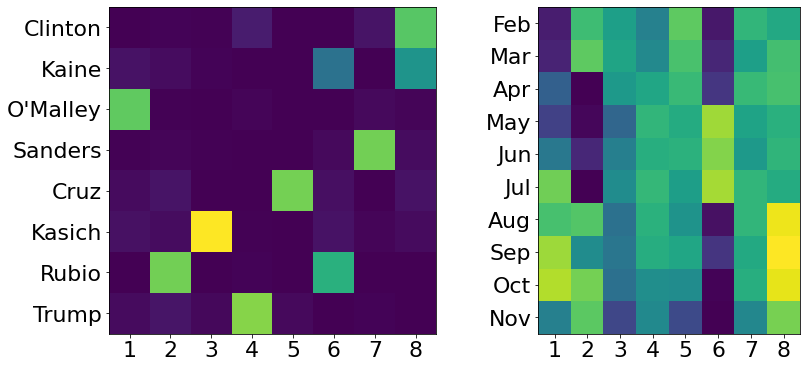


RANK 4 KEYWORDS:
------------------
Topic 1     Topic 2     Topic 3     Topic 4        
-------     -------     -------     -------        
johnkasich  marcorubio  tedcruz     berniesanders  
kasich      teammarco   cruz        people         
ohio        vote        ted         bernie         
john        florida     internet    must           
gov         flsen       choosecruz  change         

For LaTeX table...
------------------
johnkasich & marcorubio \\
kasich & teammarco \\
ohio & vote \\
john & florida \\
gov & flsen \\
tedcruz & berniesanders \\
cruz & people \\
ted & bernie \\
internet & must \\
choosecruz & change \\




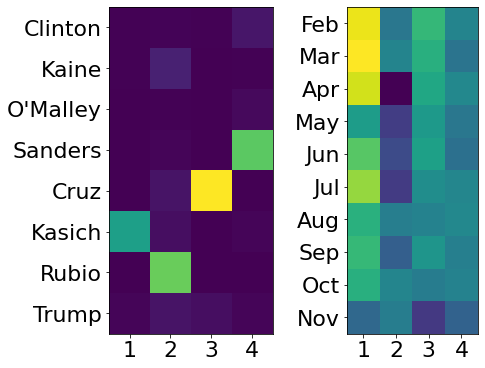


RANK 2 KEYWORDS:
------------------
Topic 1     Topic 2        
-------     -------        
marcorubio  berniesanders  
teammarco   people         
vote        bernie         
florida     must           
flsen       change         

For LaTeX table...
------------------
marcorubio \\
teammarco \\
vote \\
florida \\
flsen \\
berniesanders \\
people \\
bernie \\
must \\
change \\




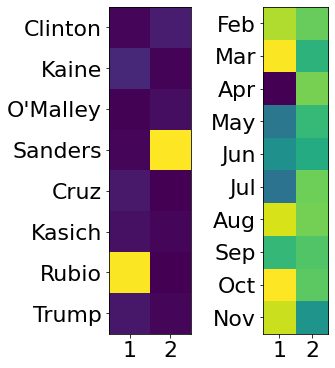

In [8]:
C = factorizations[0][2]

keywords = np.empty((7,8), dtype=object)

for i in range(keywords.shape[1]):
    keywords[0,i] = "Topic " + str(i+1)
    keywords[1,i] = "-------"

for i in range(C.shape[1]):
    col = C[:,i]
    top = col.argsort()
    top = top[-5:][::-1]

    keywords[2:,i] = words[top]

print("")
print("RANK 8 KEYWORDS:")  
print("------------------")
col_widths = [max([len(keywords[i][j]) for i in range(keywords.shape[0])])+2 for j in range(keywords.shape[1])]
for row in keywords:
    print("".join(row[i].ljust(col_widths[i]) for i in range(len(row))))

print("")
print("For LaTeX table...")  
print("------------------")
col_widths = [max([len(keywords[i][j]) for i in range(keywords.shape[0])])+2 for j in range(keywords.shape[1])]
for i, row in enumerate(keywords):
    if(i >= 2):
        print(" & ".join([row[i] for i in range(0,4)]) + " \\\\")
for i, row in enumerate(keywords):
    if(i >= 2):
        print(" & ".join([row[i] for i in range(4,8)]) + " \\\\")
        
print("")
print("")

r = 8
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(12,5))

#color = "binary"
color = "viridis"
plt.sca(axs[0])
plt.yticks(range(8), ['Clinton', 'Kaine', 'O\'Malley', 'Sanders', 'Cruz', 'Kasich', 'Rubio', 'Trump'], fontsize=22)
plt.xticks(range(r), range(1,r+1), fontsize=22)
plt.sca(axs[1])
plt.xticks(range(r), range(1,r+1), fontsize=22)
plt.yticks(range(10), ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'], fontsize=22)

axs[0].imshow(factorizations[0][0], cmap=plt.get_cmap(color))
axs[1].imshow(factorizations[0][1], cmap=plt.get_cmap(color))
plt.show()

C = factorizations[1][2]

keywords = np.empty((7,4), dtype=object)

for i in range(keywords.shape[1]):
    keywords[0,i] = "Topic " + str(i+1)
    keywords[1,i] = "-------"

for i in range(C.shape[1]):
    col = C[:,i]
    top = col.argsort()
    top = top[-5:][::-1]

    keywords[2:,i] = words[top]

print("")
print("RANK 4 KEYWORDS:")  
print("------------------")

col_widths = [max([len(keywords[i][j]) for i in range(keywords.shape[0])])+2 for j in range(keywords.shape[1])]
for row in keywords:
    print("".join(row[i].ljust(col_widths[i]) for i in range(len(row))))

print("")
print("For LaTeX table...")  
print("------------------")
col_widths = [max([len(keywords[i][j]) for i in range(keywords.shape[0])])+2 for j in range(keywords.shape[1])]
for i, row in enumerate(keywords):
    if(i >= 2):
        print(" & ".join([row[i] for i in range(0,2)]) + " \\\\")
for i, row in enumerate(keywords):
    if(i >= 2):
        print(" & ".join([row[i] for i in range(2,4)]) + " \\\\")
        
print("")
print("")

r = 4
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(7,5))

#color = "binary"
color = "viridis"
plt.sca(axs[0])
plt.yticks(range(8), ['Clinton', 'Kaine', 'O\'Malley', 'Sanders', 'Cruz', 'Kasich', 'Rubio', 'Trump'], fontsize=22)
plt.xticks(range(r), range(1,r+1), fontsize=22)
plt.sca(axs[1])
plt.xticks(range(r), range(1,r+1), fontsize=22)
plt.yticks(range(10), ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'], fontsize=22)

axs[0].imshow(factorizations[1][0], cmap=plt.get_cmap(color))
axs[1].imshow(factorizations[1][1], cmap=plt.get_cmap(color))
plt.show()

C = factorizations[2][2]

keywords = np.empty((7,2), dtype=object)

for i in range(keywords.shape[1]):
    keywords[0,i] = "Topic " + str(i+1)
    keywords[1,i] = "-------"

for i in range(C.shape[1]):
    col = C[:,i]
    top = col.argsort()
    top = top[-5:][::-1]

    keywords[2:,i] = words[top]

print("")
print("RANK 2 KEYWORDS:")  
print("------------------")

col_widths = [max([len(keywords[i][j]) for i in range(keywords.shape[0])])+2 for j in range(keywords.shape[1])]
for row in keywords:
    print("".join(row[i].ljust(col_widths[i]) for i in range(len(row))))

print("")
print("For LaTeX table...")  
print("------------------")
col_widths = [max([len(keywords[i][j]) for i in range(keywords.shape[0])])+2 for j in range(keywords.shape[1])]
for i, row in enumerate(keywords):
    if(i >= 2):
        print(" & ".join([row[i] for i in range(0,1)]) + " \\\\")
for i, row in enumerate(keywords):
    if(i >= 2):
        print(" & ".join([row[i] for i in range(1,2)]) + " \\\\")
        
print("")
print("")
r = 2
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(4.8,5))

#color = "binary"
color = "viridis"
plt.sca(axs[0])
plt.yticks(range(8), ['Clinton', 'Kaine', 'O\'Malley', 'Sanders', 'Cruz', 'Kasich', 'Rubio', 'Trump'], fontsize=22)
plt.xticks(range(r), range(1,r+1), fontsize=22)
plt.sca(axs[1])
plt.xticks(range(r), range(1,r+1), fontsize=22)
plt.yticks(range(10), ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'], fontsize=22)

axs[0].imshow(factorizations[2][0], cmap=plt.get_cmap(color))
axs[1].imshow(factorizations[2][1], cmap=plt.get_cmap(color))
plt.show()

In [9]:
for i in range(len(factorizations)):
    
    A, D, S = factorizations[i]

    approx = outer_product_np(A,D,S)
    print("Reconstruction loss:", np.linalg.norm(np.ndarray.flatten(X-approx), 2))
    print("Relative reconstruction loss:", np.linalg.norm(np.ndarray.flatten(X-approx), 2)  / np.linalg.norm(np.ndarray.flatten(X), 2))
    print()

Reconstruction loss: 7.446640570183214
Relative reconstruction loss: 0.8325597259468733

Reconstruction loss: 8.132142927391023
Relative reconstruction loss: 0.9092012194195235

Reconstruction loss: 8.548933952099423
Relative reconstruction loss: 0.9557998726025124



# Word Corpus at Mode 1

In [10]:
X_tr = np.transpose(X, (2,0,1))
factorizations = cichocki(X_tr, [8,4,2], initial_factors=[X_3, X_1, X_2])


for i in range(1, len(factorizations)):
    factorizations[i][0] = factorizations[i-1][0] @ factorizations[i][0]
factorizations = [[x[1], x[2], x[0]] for x in factorizations]

### Topics


RANK 8 KEYWORDS:
------------------
Topic 1          Topic 2     Topic 3     Topic 4  Topic 5     Topic 6        Topic 7        Topic 8    
-------          -------     -------     -------  -------     -------        -------        -------    
martinomalley    marcorubio  johnkasich  crooked  tedcruz     senate         berniesanders  trump      
hillaryclinton   teammarco   kasich      hillary  cruz        florida        people         hillary    
realdonaldtrump  vote        ohio        thank    ted         zika           bernie         donald     
campaigning      flsen       john        great    internet    venezuela      must           president  
maryland         click       gov         clinton  choosecruz  nicolasmaduro  change         timkaine   

For LaTeX table...
------------------
martinomalley & marcorubio & johnkasich & crooked \\
hillaryclinton & teammarco & kasich & hillary \\
realdonaldtrump & vote & ohio & thank \\
campaigning & flsen & john & great \\
maryland & clic

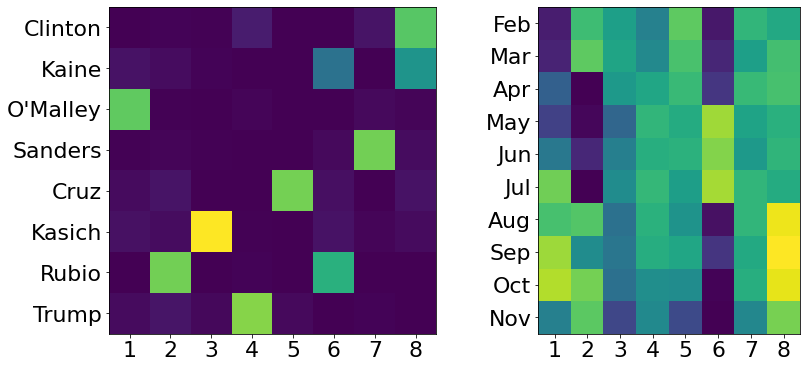


RANK 4 KEYWORDS:
------------------
Topic 1    Topic 2     Topic 3        Topic 4  
-------    -------     -------        -------  
trump      marcorubio  berniesanders  tedcruz  
hillary    teammarco   people         cruz     
donald     vote        bernie         ted      
president  flsen       must           crooked  
timkaine   click       country        thank    

For LaTeX table...
------------------
trump & marcorubio \\
hillary & teammarco \\
donald & vote \\
president & flsen \\
timkaine & click \\
berniesanders & tedcruz \\
people & cruz \\
bernie & ted \\
must & crooked \\
country & thank \\




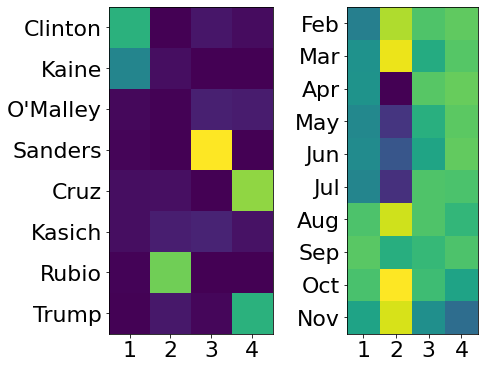


RANK 2 KEYWORDS:
------------------
Topic 1  Topic 2        
-------  -------        
tedcruz  berniesanders  
cruz     people         
ted      bernie         
hillary  must           
crooked  vote           

For LaTeX table...
------------------
tedcruz \\
cruz \\
ted \\
hillary \\
crooked \\
berniesanders \\
people \\
bernie \\
must \\
vote \\




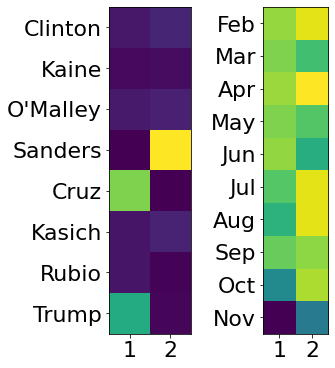

In [11]:
C = factorizations[0][2]

keywords = np.empty((7,8), dtype=object)

for i in range(keywords.shape[1]):
    keywords[0,i] = "Topic " + str(i+1)
    keywords[1,i] = "-------"

for i in range(C.shape[1]):
    col = C[:,i]
    top = col.argsort()
    top = top[-5:][::-1]

    keywords[2:,i] = words[top]

print("")
print("RANK 8 KEYWORDS:")  
print("------------------")
col_widths = [max([len(keywords[i][j]) for i in range(keywords.shape[0])])+2 for j in range(keywords.shape[1])]
for row in keywords:
    print("".join(row[i].ljust(col_widths[i]) for i in range(len(row))))

print("")
print("For LaTeX table...")  
print("------------------")
col_widths = [max([len(keywords[i][j]) for i in range(keywords.shape[0])])+2 for j in range(keywords.shape[1])]
for i, row in enumerate(keywords):
    if(i >= 2):
        print(" & ".join([row[i] for i in range(0,4)]) + " \\\\")
for i, row in enumerate(keywords):
    if(i >= 2):
        print(" & ".join([row[i] for i in range(4,8)]) + " \\\\")
        
print("")
print("")

r = 8
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(12,5))

#color = "binary"
color = "viridis"
plt.sca(axs[0])
plt.yticks(range(8), ['Clinton', 'Kaine', 'O\'Malley', 'Sanders', 'Cruz', 'Kasich', 'Rubio', 'Trump'], fontsize=22)
plt.xticks(range(r), range(1,r+1), fontsize=22)
plt.sca(axs[1])
plt.xticks(range(r), range(1,r+1), fontsize=22)
plt.yticks(range(10), ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'], fontsize=22)

axs[0].imshow(factorizations[0][0], cmap=plt.get_cmap(color))
axs[1].imshow(factorizations[0][1], cmap=plt.get_cmap(color))
plt.show()

C = factorizations[1][2]

keywords = np.empty((7,4), dtype=object)

for i in range(keywords.shape[1]):
    keywords[0,i] = "Topic " + str(i+1)
    keywords[1,i] = "-------"

for i in range(C.shape[1]):
    col = C[:,i]
    top = col.argsort()
    top = top[-5:][::-1]

    keywords[2:,i] = words[top]

print("")
print("RANK 4 KEYWORDS:")  
print("------------------")

col_widths = [max([len(keywords[i][j]) for i in range(keywords.shape[0])])+2 for j in range(keywords.shape[1])]
for row in keywords:
    print("".join(row[i].ljust(col_widths[i]) for i in range(len(row))))

print("")
print("For LaTeX table...")  
print("------------------")
col_widths = [max([len(keywords[i][j]) for i in range(keywords.shape[0])])+2 for j in range(keywords.shape[1])]
for i, row in enumerate(keywords):
    if(i >= 2):
        print(" & ".join([row[i] for i in range(0,2)]) + " \\\\")
for i, row in enumerate(keywords):
    if(i >= 2):
        print(" & ".join([row[i] for i in range(2,4)]) + " \\\\")
        
print("")
print("")

r = 4
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(7,5))

#color = "binary"
color = "viridis"
plt.sca(axs[0])
plt.yticks(range(8), ['Clinton', 'Kaine', 'O\'Malley', 'Sanders', 'Cruz', 'Kasich', 'Rubio', 'Trump'], fontsize=22)
plt.xticks(range(r), range(1,r+1), fontsize=22)
plt.sca(axs[1])
plt.xticks(range(r), range(1,r+1), fontsize=22)
plt.yticks(range(10), ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'], fontsize=22)

axs[0].imshow(factorizations[1][0], cmap=plt.get_cmap(color))
axs[1].imshow(factorizations[1][1], cmap=plt.get_cmap(color))
plt.show()

C = factorizations[2][2]

keywords = np.empty((7,2), dtype=object)

for i in range(keywords.shape[1]):
    keywords[0,i] = "Topic " + str(i+1)
    keywords[1,i] = "-------"

for i in range(C.shape[1]):
    col = C[:,i]
    top = col.argsort()
    top = top[-5:][::-1]

    keywords[2:,i] = words[top]

print("")
print("RANK 2 KEYWORDS:")  
print("------------------")

col_widths = [max([len(keywords[i][j]) for i in range(keywords.shape[0])])+2 for j in range(keywords.shape[1])]
for row in keywords:
    print("".join(row[i].ljust(col_widths[i]) for i in range(len(row))))

print("")
print("For LaTeX table...")  
print("------------------")
col_widths = [max([len(keywords[i][j]) for i in range(keywords.shape[0])])+2 for j in range(keywords.shape[1])]
for i, row in enumerate(keywords):
    if(i >= 2):
        print(" & ".join([row[i] for i in range(0,1)]) + " \\\\")
for i, row in enumerate(keywords):
    if(i >= 2):
        print(" & ".join([row[i] for i in range(1,2)]) + " \\\\")
        
print("")
print("")
r = 2
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(4.8,5))

#color = "binary"
color = "viridis"
plt.sca(axs[0])
plt.yticks(range(8), ['Clinton', 'Kaine', 'O\'Malley', 'Sanders', 'Cruz', 'Kasich', 'Rubio', 'Trump'], fontsize=22)
plt.xticks(range(r), range(1,r+1), fontsize=22)
plt.sca(axs[1])
plt.xticks(range(r), range(1,r+1), fontsize=22)
plt.yticks(range(10), ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'], fontsize=22)

axs[0].imshow(factorizations[2][0], cmap=plt.get_cmap(color))
axs[1].imshow(factorizations[2][1], cmap=plt.get_cmap(color))
plt.show()

In [12]:
for i in range(len(factorizations)):
    
    A, D, S = factorizations[i]

    approx = outer_product_np(A,D,S)
    print("Reconstruction loss:", np.linalg.norm(np.ndarray.flatten(X-approx), 2))
    print("Relative reconstruction loss:", np.linalg.norm(np.ndarray.flatten(X-approx), 2)  / np.linalg.norm(np.ndarray.flatten(X), 2))
    print()

Reconstruction loss: 7.446640570183214
Relative reconstruction loss: 0.8325597259468733

Reconstruction loss: 8.00698548103955
Relative reconstruction loss: 0.8952081915229146

Reconstruction loss: 8.425398149189457
Relative reconstruction loss: 0.9419881499544274

